# Imbalanced Data: ROS, RUS, SMOTE, dan SMOTE-ENN



---
### Struktur Notebook
1. Setup & Instalasi
2. Memuat Dataset (CSV Anda **atau** contoh dataset)
3. EDA singkat & Cek Imbalance
4. Baseline Model (tanpa resampling)
5. Eksperimen Resampling: ROS, RUS, SMOTE, SMOTE-ENN
6. Perbandingan Metrik & Visualisasi
7. Ringkasan & Checklist Laporan


## 1) Setup & Instalasi
**Penjelasan**: Cell ini menginstal dan mengimpor *library* yang diperlukan.
- `pandas`, `numpy`: manipulasi data.
- `matplotlib`: visualisasi (tanpa seaborn sesuai aturan).
- `scikit-learn`: preprocessing (`ColumnTransformer`, `OneHotEncoder`, `StandardScaler`), model (`LogisticRegression`, `RandomForestClassifier`), evaluasi (`StratifiedKFold`, `cross_validate`).
- `imblearn`: *resampler* (ROS, RUS, SMOTE, SMOTE-ENN) dan `Pipeline` khusus yang kompatibel dengan resampling.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import StratifiedKFold,  cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline  
RANDOM_STATE = 42

## 2) Memuat Dataset


In [ ]:
# Load data

df = pd.read_csv("train.csv")
target_col = "Survived"    
df.columns = df.columns.str.strip()

df.head()

## 3) EDA Singkat & Cek Imbalance
**Penjelasan**: Kita lihat ukuran data, tipe kolom, *missing values*, dan distribusi kelas target.


Ukuran data: (891, 8)


Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
Survived      int64
dtype: object


Missing values per kolom:
 Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Survived      0
dtype: int64

Distribusi kelas:
Survived
0    549
1    342
Name: count, dtype: int64


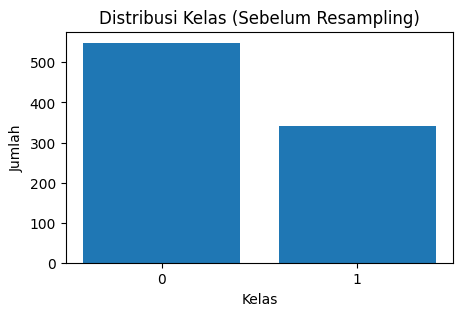

In [38]:
print("Ukuran data:", df.shape)
display(df.dtypes)
print("\nMissing values per kolom:\n", df.isna().sum())

assert target_col in df.columns, f"Kolom target '{target_col}' tidak ditemukan!"

# Distribusi kelas
y = df[target_col]
class_counts = y.value_counts().sort_index()
print("\nDistribusi kelas:")
print(class_counts)

# Plot bar sederhana (matplotlib only)
plt.figure(figsize=(5,3))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Distribusi Kelas (Sebelum Resampling)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

## 4) Menentukan Fitur & *Preprocessing*
**Penjelasan**:
- Pisahkan `X` (fitur) dan `y` (target).
- Deteksi kolom numerik vs kategorikal.
- Buat `ColumnTransformer` untuk *encoding* kategori & *scaling* numerik.


In [32]:

use_cols   = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Survived']
df = df[use_cols].copy()

X = df.drop(columns=['Survived'])
y = df['Survived']

num_cols = ['Age','SibSp','Parch','Fare']
cat_cols = ['Pclass','Sex','Embarked']  # Pclass diperlakukan kategori (sering lebih bagus)

# Kompatibilitas OneHotEncoder (sklearn lama pakai 'sparse', baru pakai 'sparse_output')
ohe_kwargs = {}
if tuple(int(x) for x in sklearn.__version__.split('.')[:2]) >= (1, 2):
    ohe_kwargs['sparse_output'] = False
else:
    ohe_kwargs['sparse'] = False

num_pipe = SkPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = SkPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', **ohe_kwargs))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols),
    ],
    remainder='drop'
)

print("Jumlah NaN setelah seleksi fitur:")
print(X.isna().sum())


Jumlah NaN setelah seleksi fitur:
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


## 5) Baseline Model (Tanpa Resampling)
**Penjelasan**: Kita evaluasi model tanpa penyeimbangan sebagai *pembanding*. Gunakan `StratifiedKFold` agar proporsi kelas konsisten di setiap *fold*. Skor yang dilihat: ROC-AUC, F1, Precision, Recall, Balanced Accuracy.


In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_model(pipeline, X, y, cv):
    scoring = {
        "roc_auc": "roc_auc",
        "f1": "f1",
        "precision": "precision",
        "recall": "recall",
        "balanced_accuracy": "balanced_accuracy",
    }
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return {k: float(np.mean(v)) for k, v in scores.items() if k.startswith("test_")}

baseline_clf = LogisticRegression(max_iter=500, class_weight=None)
baseline_pipe = SkPipeline(steps=[
    ("preprocess", preprocess),
    ("clf", baseline_clf),
])

baseline_scores = eval_model(baseline_pipe, X, y, cv)
baseline_scores

{'test_roc_auc': 0.8513981884591237,
 'test_f1': 0.7257926039978063,
 'test_precision': 0.7547281330780817,
 'test_recall': 0.7015771526001705,
 'test_balanced_accuracy': 0.7788452902283588}

## 6) Eksperimen Resampling (di dalam Pipeline)
**Penjelasan**: Kita bandingkan 4 metode:
- **ROS**: `RandomOverSampler`
- **RUS**: `RandomUnderSampler`
- **SMOTE**: `SMOTE`
- **SMOTE-ENN**: `SMOTEENN`

Semua ditempatkan **di awal** `Pipeline` (versi `imblearn.pipeline.Pipeline`) agar resampling hanya terjadi pada data *train* di setiap fold (*anti leakage*).

In [34]:
from collections import OrderedDict
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline  # pastikan dari imblearn

resamplers = OrderedDict([
    ("ROS", RandomOverSampler()),
    ("RUS", RandomUnderSampler()),
    ("SMOTE", SMOTE()),
    ("SMOTE-ENN", SMOTEENN()),
])

results = {"Baseline": baseline_scores}

for name, sampler in resamplers.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),                  # <-- PREPROCESS DULU
        ("resample", sampler),                       # <-- BARU RESAMPLING
        ("clf", LogisticRegression(max_iter=1000)),  # <-- LALU MODEL
    ])
    scores = eval_model(pipe, X, y, cv)
    results[name] = scores

pd.DataFrame(results).T


,test_roc_auc,test_f1,test_precision,test_recall,test_balanced_accuracy
Baseline,0.851398,0.725793,0.754728,0.701577,0.778845
ROS,0.852483,0.738450,0.714884,0.765814,0.787269
RUS,0.846675,0.733941,0.708463,0.762958,0.783114
SMOTE,0.850399,0.731900,0.714643,0.751279,0.781828
SMOTE-ENN,0.839899,0.729093,0.697963,0.765772,0.779049


## 7) Visualisasi Perbandingan Skor
**Penjelasan**: Grafik batang sederhana untuk membandingkan metrik antar-metode. (Satu plot per metrik.)

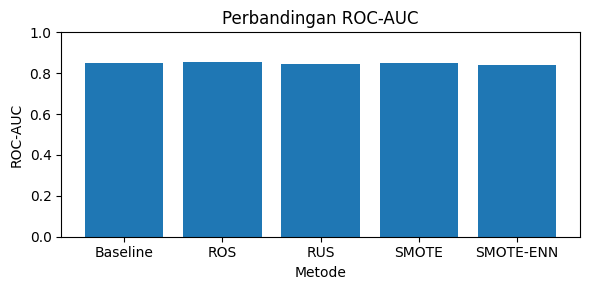

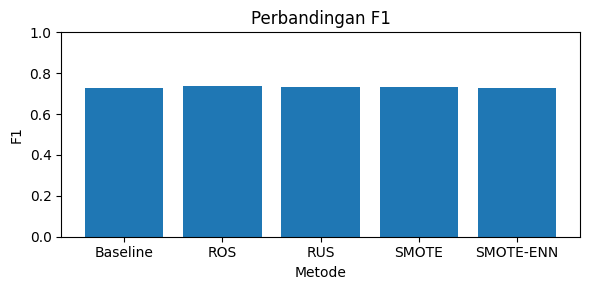

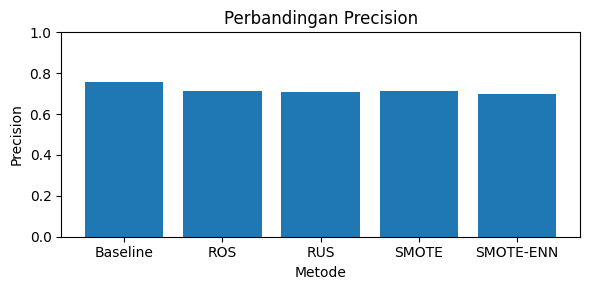

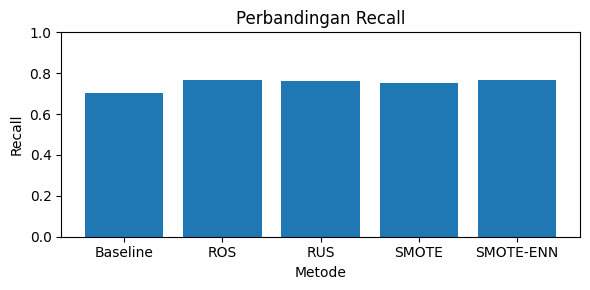

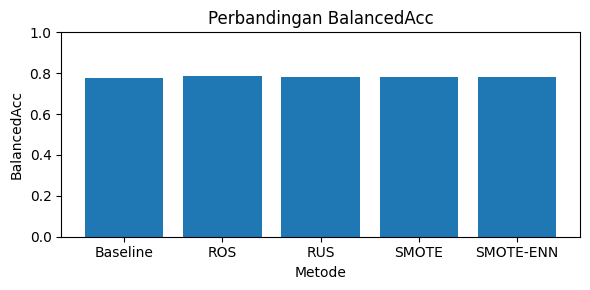

In [40]:
res_df = pd.DataFrame(results).T
metrics = ["test_roc_auc", "test_f1", "test_precision", "test_recall", "test_balanced_accuracy"]
res_df = res_df[metrics]
res_df = res_df.rename(columns={
    "test_roc_auc": "ROC-AUC",
    "test_f1": "F1",
    "test_precision": "Precision",
    "test_recall": "Recall",
    "test_balanced_accuracy": "BalancedAcc",
})
for col in res_df.columns:
    plt.figure(figsize=(6,3))
    plt.bar(res_df.index.astype(str), res_df[col].values)
    plt.title(f"Perbandingan {col}")
    plt.xlabel("Metode")
    plt.ylabel(col)
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 8) Distribusi Kelas: Sebelum vs Sesudah (Contoh Satu Metode)
**Penjelasan**: Kita contohkan dengan SMOTE untuk melihat perubahan distribusi kelas.


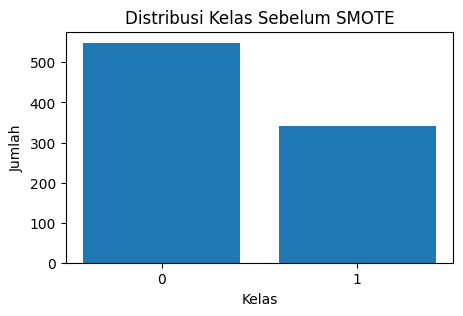

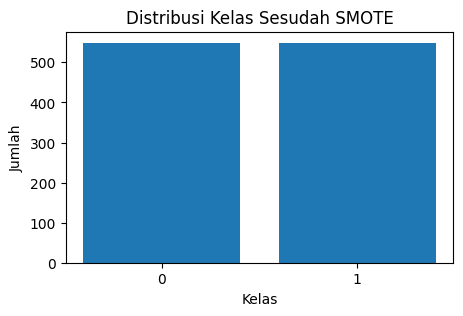

In [ ]:
# Ubah X jadi numerik pakai preprocess
Xp = preprocess.fit_transform(X)   # Hanya untuk demo plot

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
Xp_res, y_res = smote.fit_resample(Xp, y)

before_counts = y.value_counts().sort_index()
after_counts  = pd.Series(y_res).value_counts().sort_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.bar(before_counts.index.astype(str), before_counts.values)
plt.title("Distribusi Kelas Sebelum SMOTE"); plt.xlabel("Kelas"); plt.ylabel("Jumlah")
plt.show()

plt.figure(figsize=(5,3))
plt.bar(after_counts.index.astype(str), after_counts.values)
plt.title("Distribusi Kelas Sesudah SMOTE"); plt.xlabel("Kelas"); plt.ylabel("Jumlah")
plt.show()


## 9) Glosarium  *Library* & Fungsi
- **pandas (`pd`)**: baca CSV (`pd.read_csv`), *dataframe* untuk manipulasi tabular.
- **numpy (`np`)**: operasi numerik/array, bantu statistik & reshape.
- **matplotlib (`plt`)**: buat grafik dasar (bar, line) tanpa *style* khusus.
- **scikit-learn**:
  - `ColumnTransformer`: menggabungkan *preprocessing* untuk kolom numerik/kategorikal.
  - `OneHotEncoder`: mengubah kolom kategorikal ke *one-hot vectors*.
  - `StandardScaler`: men-standarkan fitur numerik (mean=0, std=1).
  - `StratifiedKFold`: *CV* yang mempertahankan proporsi kelas di tiap *fold*.
  - `Pipeline` (sklearn): rantai *preprocess -> model* (tanpa resampling).
  - `LogisticRegression`, `RandomForestClassifier`: model klasifikasi.
  - `cross_validate`: evaluasi berbagai metrik via CV.
- **imbalanced-learn (`imblearn`)**:
  - `RandomOverSampler` (ROS): menduplikasi contoh kelas minoritas secara acak.
  - `RandomUnderSampler` (RUS): mengurangi contoh kelas mayoritas secara acak.
  - `SMOTE`: *synthetic minority oversampling technique*, membuat sampel minoritas sintetis.
  - `SMOTEENN`: kombinasi SMOTE + Edited Nearest Neighbors (membersihkan *noise* setelah oversampling).
  - `Pipeline` (imblearn): versi *pipeline* yang kompatibel dengan tahapan resampling.


In [ ]:
out = res_df.copy()
out_path = Path("imbalanced_results.csv")
out.to_csv(out_path, index=True)
out_path, out.shape